# EDA for InstaCart

## 1. Load Data Files
Read orders.csv, order_products__prior.csv, and order_products__train.csv into DataFrames.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path('..') / 'data'

orders = pd.read_csv(DATA_DIR / 'orders.csv')
order_products_prior = pd.read_csv(DATA_DIR / 'order_products__prior.csv')
order_products_train = pd.read_csv(DATA_DIR / 'order_products__train.csv')
products = pd.read_csv(DATA_DIR / 'products.csv')

## 2. Inspect Schema and Basic Counts
Display column names, row counts, and sample records to verify successful loading.

In [2]:
print("Orders columns:", orders.columns.tolist())
print("Orders rows:", len(orders))
display(orders.head())

print("Order Products Prior columns:", order_products_prior.columns.tolist())
print("Order Products Prior rows:", len(order_products_prior))
display(order_products_prior.head())

print("Order Products Train columns:", order_products_train.columns.tolist())
print("Order Products Train rows:", len(order_products_train))
display(order_products_train.head())

Orders columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Orders rows: 3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Order Products Prior columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Order Products Prior rows: 32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Order Products Train columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Order Products Train rows: 1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## 3. Top 10 Best-Sellers Bar Chart
Aggregate product order counts and plot a horizontal bar chart of the top 10 products.

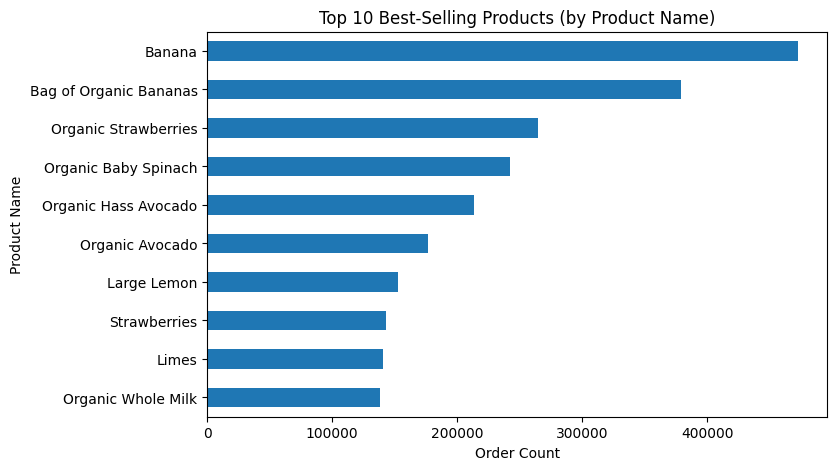

In [13]:
product_counts = order_products_prior.merge(products, on='product_id', how='left')["product_name"].value_counts().head(10)
plt.figure(figsize=(8, 5))
product_counts.sort_values().plot(kind="barh")
plt.title("Top 10 Best-Selling Products (by Product Name)")
plt.xlabel("Order Count")
plt.ylabel("Product Name")
plt.show()

## 4. Basket Size Histogram
Compute number of items per order and plot a histogram to estimate typical basket size.

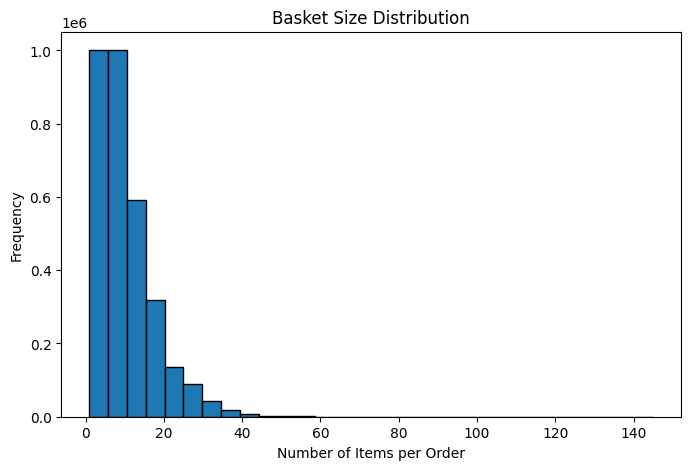

In [24]:
basket_sizes = order_products_prior.groupby("order_id").size()
plt.figure(figsize=(8, 5))
plt.hist(basket_sizes, bins=30, edgecolor="black")
plt.title("Basket Size Distribution")
plt.xlabel("Number of Items per Order")
plt.ylabel("Frequency")
plt.show()

In [15]:
basket_sizes.describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
dtype: float64

## 5. Order DOW vs Hour Heatmap
Create a pivot table of order counts by day of week and hour of day, then plot a heatmap.

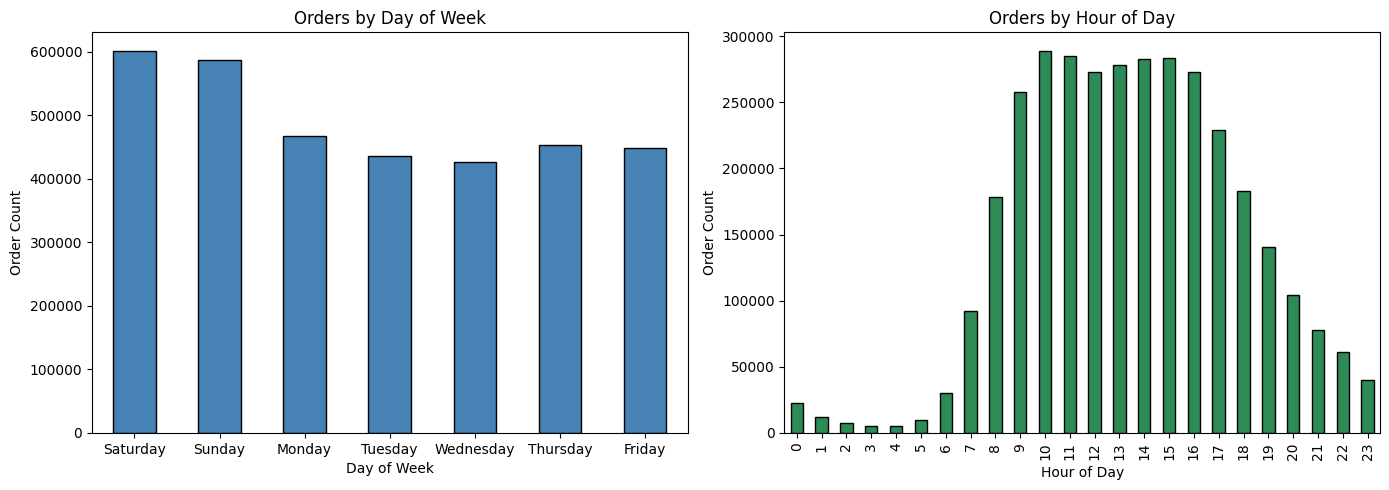

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

orders["order_dow"].value_counts().sort_index().plot(
    kind="bar",
    ax=axes[0],
    color="steelblue",
    edgecolor="black"
)
axes[0].set_title("Orders by Day of Week")
axes[0].set_xticklabels(
    ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
    rotation=0
)
axes[0].set_xlabel("Day of Week")
axes[0].set_ylabel("Order Count")

orders["order_hour_of_day"].value_counts().sort_index().plot(
    kind="bar",
    ax=axes[1],
    color="seagreen",
    edgecolor="black"
)
axes[1].set_title("Orders by Hour of Day")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Order Count")

plt.tight_layout()
plt.show()

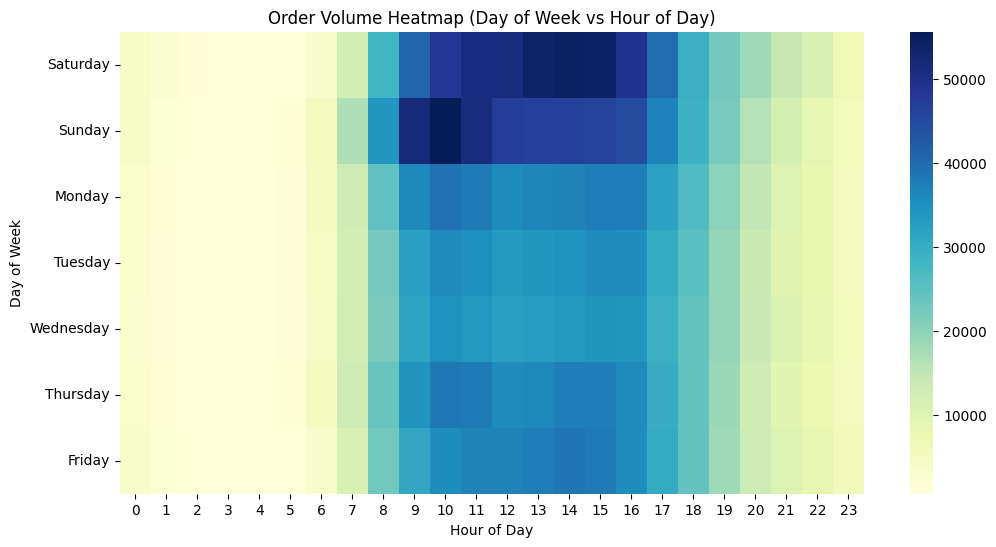

In [20]:
dow_hour_counts = orders.pivot_table(
    index="order_dow",
    columns="order_hour_of_day",
    values="order_id",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(dow_hour_counts, cmap="YlGnBu")
plt.title("Order Volume Heatmap (Day of Week vs Hour of Day)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
ax.set_yticklabels(
    ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
    rotation=0
)
plt.show()

## 6. Global Reorder Rate Calculation
Compute reorder rate as Reorder Rate = Total Reordered Items / Total Items Purchased and display the value.

In [6]:
total_items = len(order_products_prior) + len(order_products_train)
total_reordered = order_products_prior["reordered"].sum() + order_products_train["reordered"].sum()

reorder_rate = total_reordered / total_items
print(f"Global Reorder Rate: {reorder_rate:.4f}")

Global Reorder Rate: 0.5901


## 7. Unique Products per User Distribution
Calculate unique products per user and plot the distribution as a histogram.

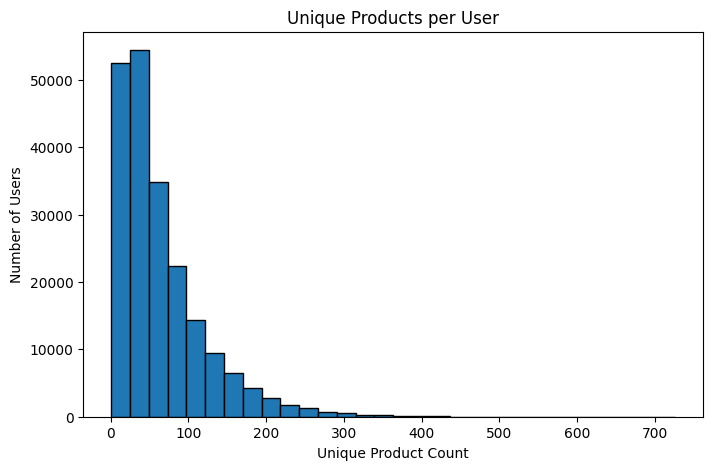

In [22]:
user_orders = orders[["order_id", "user_id"]]
prior_with_users = order_products_prior.merge(user_orders, on="order_id", how="left")

unique_products_per_user = prior_with_users.groupby("user_id")["product_id"].nunique()

plt.figure(figsize=(8, 5))
plt.hist(unique_products_per_user, bins=30, edgecolor="black")
plt.title("Unique Products per User")
plt.xlabel("Unique Product Count")
plt.ylabel("Number of Users")
plt.show()

In [23]:
unique_products_per_user.describe()

count    206209.000000
mean         64.536238
std          56.592339
min           1.000000
25%          25.000000
50%          48.000000
75%          86.000000
max         726.000000
Name: product_id, dtype: float64

## 8. Interaction Matrix Sparsity Calculation
Compute sparsity as Sparsity = 1 - (Total Entries / (Total Users × Total Products)) and report the result.

In [8]:
total_users = orders["user_id"].nunique()
total_products = pd.concat([
    order_products_prior["product_id"],
    order_products_train["product_id"]
]).nunique()

total_entries = len(order_products_prior) + len(order_products_train)

sparsity = 1 - (total_entries / (total_users * total_products))
print(f"Interaction Matrix Sparsity: {sparsity:.6f}")

Interaction Matrix Sparsity: 0.996699


## 9. Days Since Prior Order Histogram
Plot the histogram of days_since_prior_order to reveal weekly/monthly spikes.

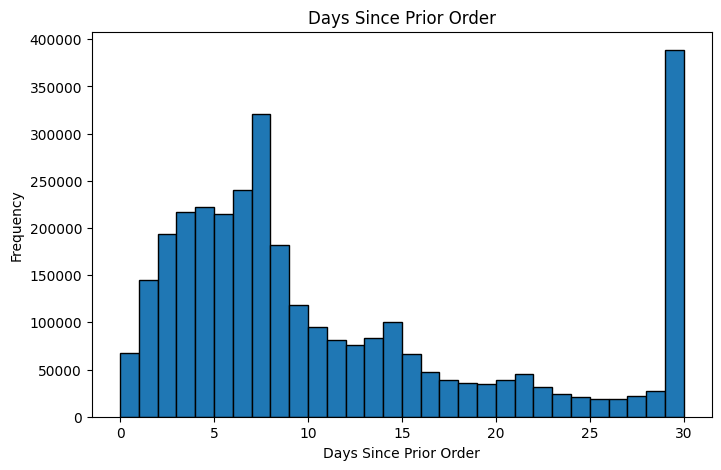

In [ ]:
plt.figure(figsize=(8, 5))
orders["days_since_prior_order"].dropna().plot(kind="hist", bins=30, edgecolor="black")
plt.title("Days Since Prior Order")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Frequency")
plt.show()

In [25]:
orders["days_since_prior_order"].dropna().describe()

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

# Facts from the analysis

- Average of 10 products per order per user. Total number of products: ~50k

- Independently, saturday and sunday and from 9am to 5pm are the most popular days / times to buy

- Together, saturday from 1pm to 3pm and sunday from 9am to 11am

- **High reorder rate**: Almost 60% of users bought the same stuff again!

- **Sparse utility matrix**: 99% sparsity in the utility matrix

- Peaks in 7 days and 30 days in the Days since Prior Order plot. This means users buy their products weekly or monthly

# Conclusions

Due to the high global reorder rate and clear weekly/monthly periodicity in order cadence, a history-based candidate generator provides strong recall. The extreme sparsity of the user-item matrix further weakens standard collaborative filtering.

These findings support using a feature-based ranker (e.g., XGBoost) that can incorporate temporal and user history signals directly to rank candidates more effectively.